In [180]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 20

In [181]:
df_fx_data = pd.read_csv('SeaPlaneTravel.csv')
df_fx_data

,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121
5,2003-06,135
6,2003-07,148
7,2003-08,148
8,2003-09,136
9,2003-10,119


In [182]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Month'])
df_fx_data.head()

,Month,#Passengers,Date
0,2003-01,112,2003-01-01
1,2003-02,118,2003-02-01
2,2003-03,132,2003-03-01
3,2003-04,129,2003-04-01
4,2003-05,121,2003-05-01


In [183]:
indexed_df = df_fx_data.set_index('Date')
indexed_df.head()

,Month,#Passengers
Date,,
2003-01-01,2003-01,112
2003-02-01,2003-02,118
2003-03-01,2003-03,132
2003-04-01,2003-04,129
2003-05-01,2003-05,121


In [184]:
indexed_df.tail()

,Month,#Passengers
Date,,
2015-08-01,2015-08,606
2015-09-01,2015-09,508
2015-10-01,2015-10,461
2015-11-01,2015-11,390
2015-12-01,2015-12,432


In [185]:
ts = indexed_df['#Passengers']
ts.head(5)

Date
2003-01-01    112
2003-02-01    118
2003-03-01    132
2003-04-01    129
2003-05-01    121
Name: #Passengers, dtype: int64

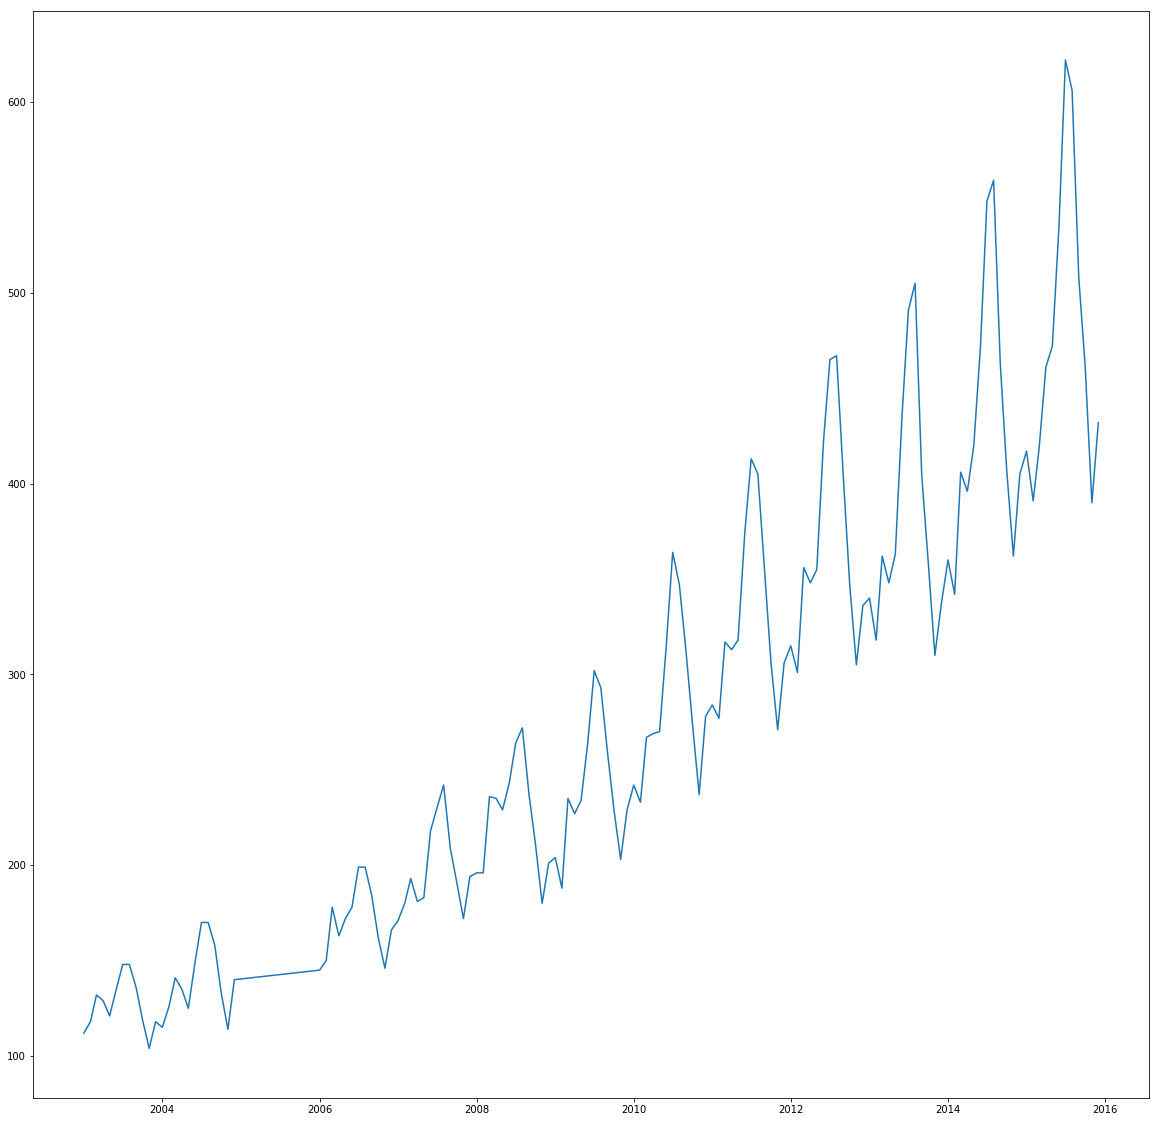

In [186]:
plt.plot(ts)

In [187]:
ts_month=ts

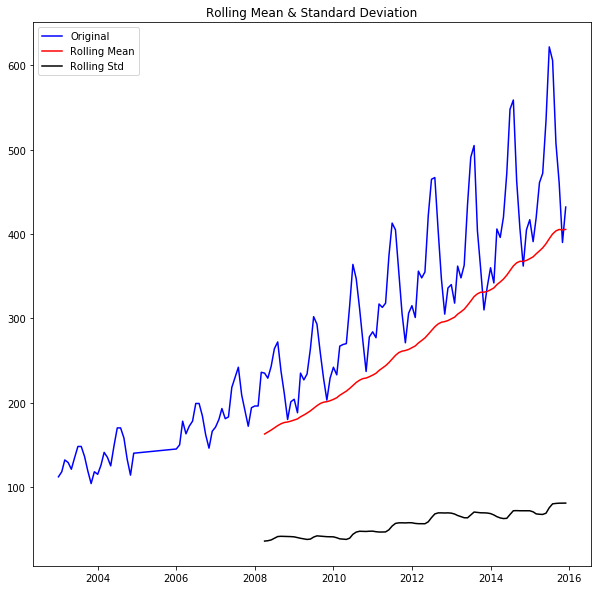

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [188]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rcParams['figure.figsize'] = 10, 10
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts_month)

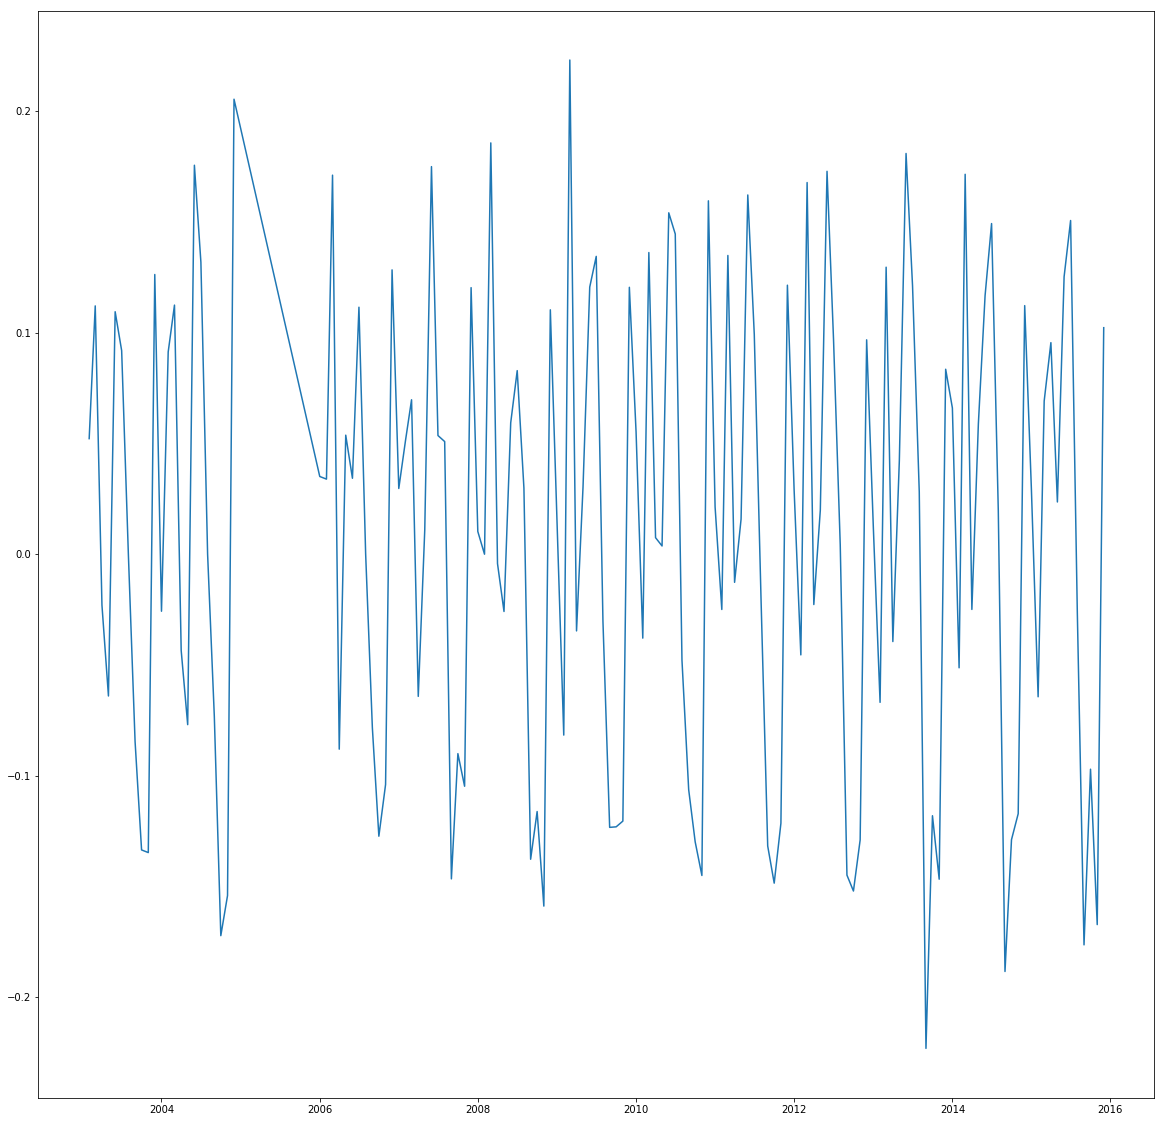

In [213]:
ts_month_log = np.log(ts_month)
ts_month_log_diff = ts_month_log - ts_month_log.shift()
plt.plot(ts_month_log_diff)

In [190]:
print(ts_month_log_diff[:5],ts_month_log[:5])

Date
2003-01-01         NaN
2003-02-01    0.052186
2003-03-01    0.112117
2003-04-01   -0.022990
2003-05-01   -0.064022
Name: #Passengers, dtype: float64 Date
2003-01-01    4.718499
2003-02-01    4.770685
2003-03-01    4.882802
2003-04-01    4.859812
2003-05-01    4.795791
Name: #Passengers, dtype: float64


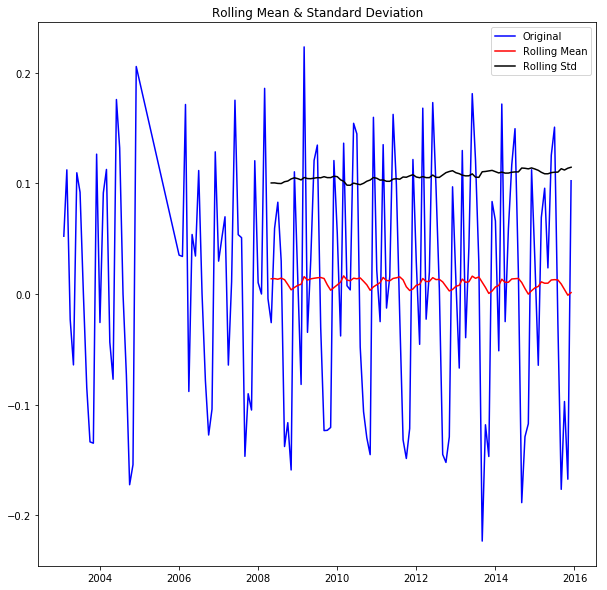

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [191]:
ts_month_log_diff.dropna(inplace=True)
test_stationarity(ts_month_log_diff)

In [192]:
#ACF and PACF
lag_acf = acf(ts_month_log_diff)
lag_pacf = pacf(ts_month_log_diff, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

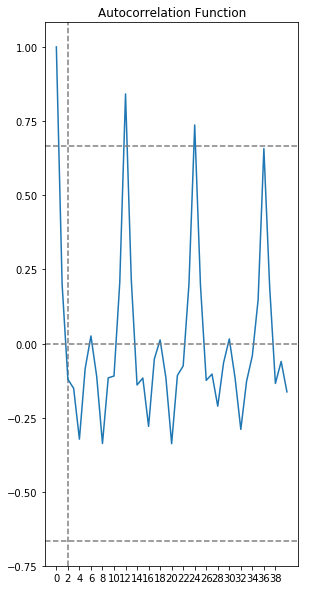

In [193]:
#Plot ACF: 
plt.subplot(121)
plt.rcParams['figure.figsize'] = 20, 20
plt.xticks(np.arange(0, 40,2))
plt.axvline(x=2,linestyle='--',color='gray')
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

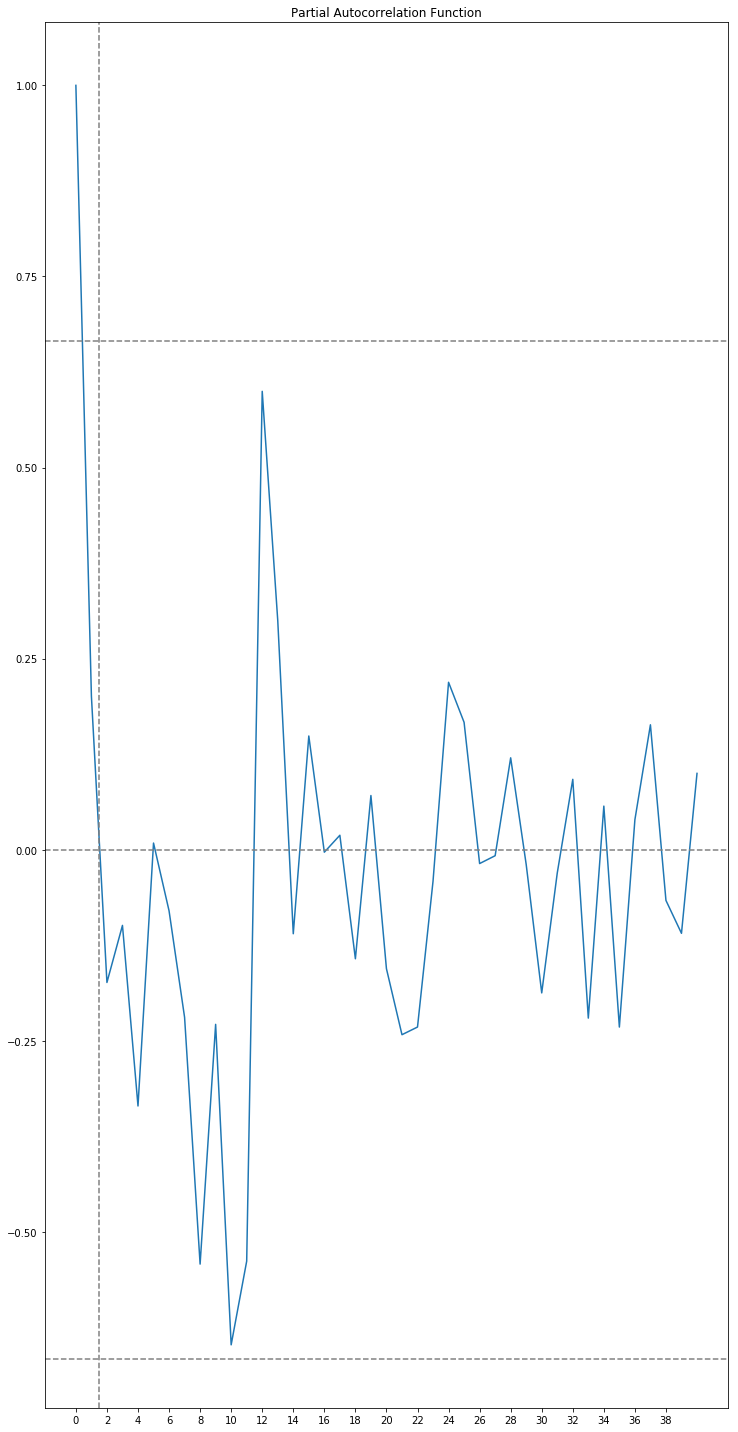

In [194]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.xticks(np.arange(0, 40,2))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axvline(x=1.5,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_month_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [195]:
size = int(len(ts_month_log) - 15)
train, test = ts_month_log[0:size], ts_month_log[size:len(ts_month_log)]
history = [x for x in train]
predictions = list()

In [196]:
size = int(len(ts_month_log) - 15)
train, test = ts_month_log[0:size], ts_month_log[size:len(ts_month_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...


predicted=411.456238, expected=432.000000


In [197]:
predictions

[6.073817848420645,
 6.023193519078388,
 5.958787963605512,
 6.122263260574817,
 6.1065944039083915,
 6.031060807037261,
 6.127347040501345,
 6.198704272415393,
 6.187919280272407,
 6.307582273515781,
 6.4157789140060535,
 6.335156821228764,
 6.171589865550806,
 6.1490368757983935,
 6.019702667164271]

In [ ]:
predictions_ARIMA_log = pd.Series(ts_week_log.ix[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())

In [198]:
history

[4.718498871295094,
 4.770684624465665,
 4.882801922586371,
 4.859812404361672,
 4.795790545596741,
 4.90527477843843,
 4.997212273764115,
 4.997212273764115,
 4.912654885736052,
 4.77912349311153,
 4.6443908991413725,
 4.770684624465665,
 4.74493212836325,
 4.836281906951478,
 4.948759890378168,
 4.90527477843843,
 4.8283137373023015,
 5.003946305945459,
 5.135798437050262,
 5.135798437050262,
 5.062595033026967,
 4.890349128221754,
 4.736198448394496,
 4.941642422609304,
 4.976733742420574,
 5.0106352940962555,
 5.181783550292085,
 5.093750200806762,
 5.147494476813453,
 5.181783550292085,
 5.293304824724492,
 5.293304824724492,
 5.214935757608986,
 5.087596335232384,
 4.983606621708336,
 5.111987788356544,
 5.14166355650266,
 5.19295685089021,
 5.262690188904886,
 5.198497031265826,
 5.209486152841421,
 5.384495062789089,
 5.438079308923196,
 5.488937726156687,
 5.342334251964811,
 5.25227342804663,
 5.147494476813453,
 5.267858159063328,
 5.278114659230517,
 5.278114659230517,
 5.4

In [199]:
z1=pd.DataFrame({'Pred':predictions}).apply(np.exp)

In [200]:
didx = pd.DatetimeIndex(start ='2015-12-01', freq ='M',periods = len(z1))
didx

D:\softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """Entry point for launching an IPython kernel.


DatetimeIndex(['2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
               '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31', '2017-02-28'],
              dtype='datetime64[ns]', freq='M')

In [201]:
z1.index=didx
z1

,Pred
2015-12-31,434.335748
2016-01-31,412.895081
2016-02-29,387.140611
2016-03-31,455.895338
2016-04-30,448.807652
2016-05-31,416.156257
2016-06-30,458.218911
2016-07-31,492.110986
2016-08-31,486.832091
2016-09-30,548.716697


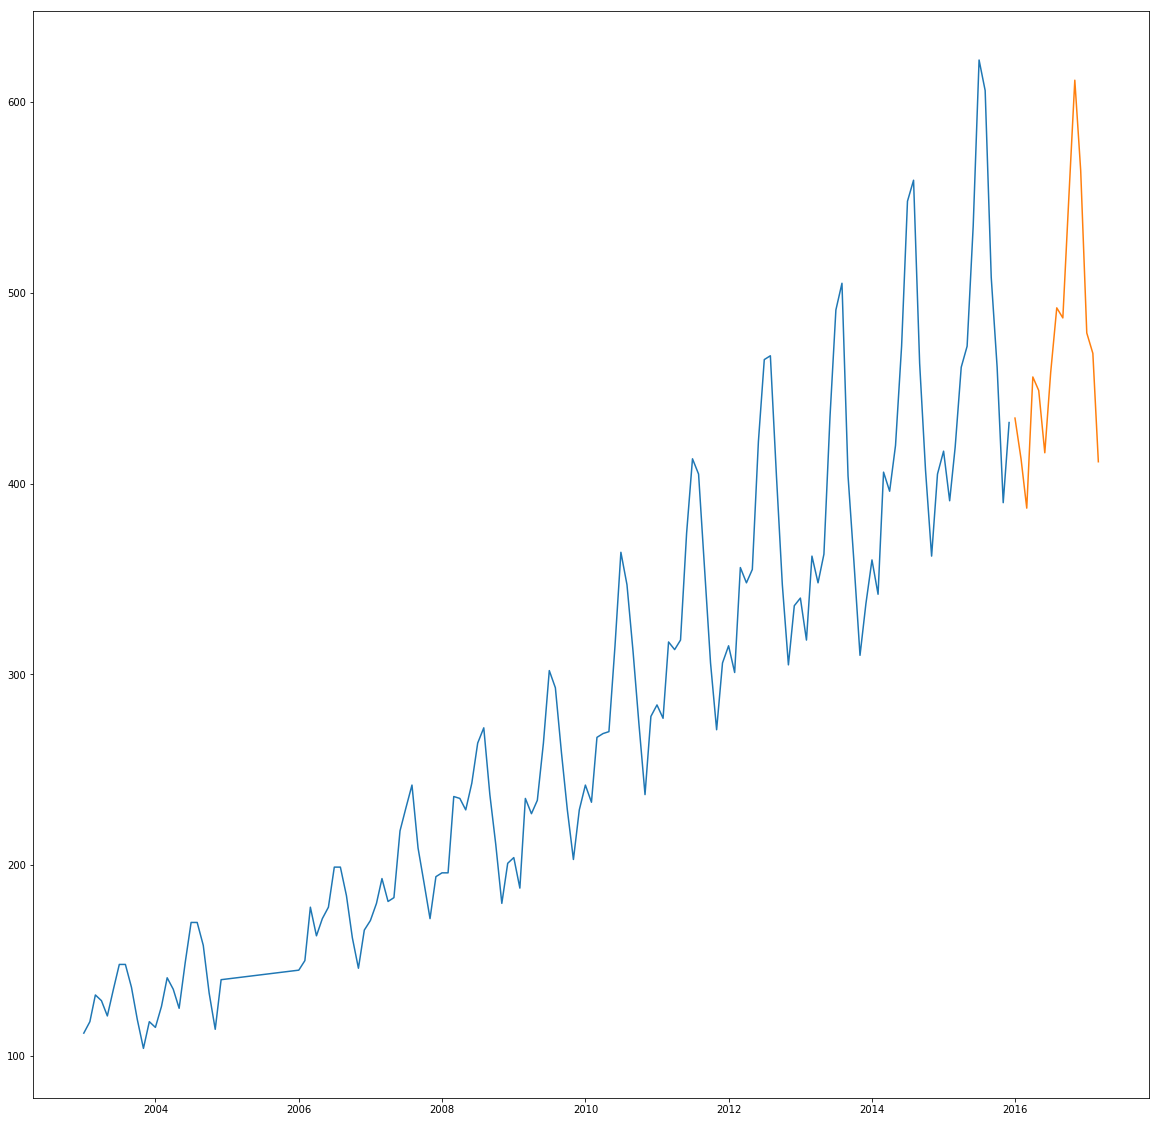

In [202]:
plt.plot(ts)
plt.plot(z1)